In [3]:
from data_loader import clean_data, create_datasets, prepare_datasets

2024-05-01 00:13:58.521964: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 00:13:58.616566: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 00:13:58.616707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 00:13:58.623580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 00:13:58.648610: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-01 00:13:58.650100: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
from data_loader import clean_data, create_datasets, prepare_datasets

# Example usage
train_dir = '../../Skin_Data/Train'
clean_data(train_dir)  # Cleaning data
train_ds, val_ds = create_datasets(train_dir)  # Creating datasets
train_ds, val_ds = prepare_datasets(train_ds, val_ds)  # Applying data augmentation and prefetching


Deleted 0 corrupted images from ../../Skin_Data/Train
Found 84 files belonging to 2 classes.
Using 68 files for training.
Using 16 files for validation.


### Build a model
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using [KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.

In [6]:


import keras
from keras import layers
from keras.models import Model
from keras.applications import VGG16  # You can choose any other as needed

image_size = (180, 180)
batch_size = 128

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)

### Training the model

In [7]:
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/15


2024-05-01 00:28:27.483533: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 282009600 exceeds 10% of free system memory.
2024-05-01 00:28:28.242489: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 282009600 exceeds 10% of free system memory.
2024-05-01 00:28:29.866118: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 282009600 exceeds 10% of free system memory.
2024-05-01 00:28:30.511423: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 282009600 exceeds 10% of free system memory.
2024-05-01 00:28:30.516250: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 141004800 exceeds 10% of free system memory.


1/1 ━━━━━━━━━━━━━━━━━━━━ 90s 90s/step - acc: 0.5441 - loss: 0.6659 - val_acc: 0.5000 - val_loss: 0.6932
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 75s 75s/step - acc: 0.7059 - loss: 0.5034 - val_acc: 0.5000 - val_loss: 0.6933
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 71s 71s/step - acc: 0.8088 - loss: 0.3847 - val_acc: 0.5000 - val_loss: 0.6933
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 72s 72s/step - acc: 0.7794 - loss: 0.3904 - val_acc: 0.5000 - val_loss: 0.6933
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 70s 70s/step - acc: 0.8824 - loss: 0.3264 - val_acc: 0.5000 - val_loss: 0.6934
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 74s 74s/step - acc: 0.8676 - loss: 0.2927 - val_acc: 0.5000 - val_loss: 0.6934
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 74s 74s/step - acc: 0.8971 - loss: 0.2668 - val_acc: 0.5000 - val_loss: 0.6935
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 75s 75s/step - acc: 0.9265 - loss: 0.2223 - val_acc: 0.5000 - val_loss: 0.6936
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 78s 78s/step - acc: 0.8971 - loss: 0.1979 - val_acc: 0.

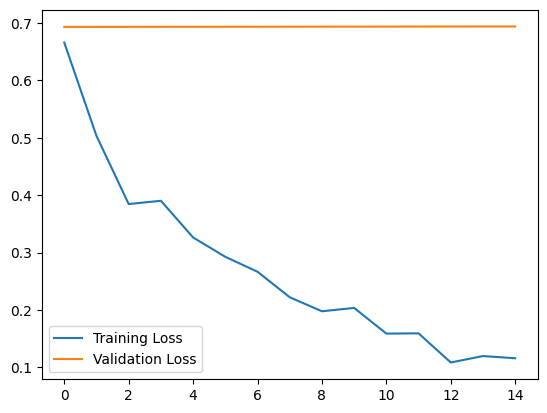

In [9]:
import matplotlib.pyplot as plt

plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

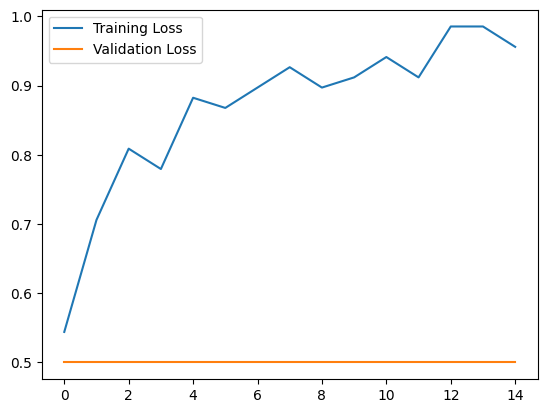

In [10]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

## Transfer learning
Now we will follow [Keras Transfer Learning Example](https://keras.io/examples/vision/keypoint_detection/), which is setup for a different task (object detection).

In [11]:
def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [12]:
model2 = make_transfer_model(input_shape=image_size + (3,), num_classes=2)

/tmp/ipykernel_1530/1277498354.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model2.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - acc: 0.4559 - loss: 0.8751 - val_acc: 0.5625 - val_loss: 0.6119
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - acc: 0.5588 - loss: 0.8856 - val_acc: 0.5625 - val_loss: 0.6018
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - acc: 0.5000 - loss: 0.8234 - val_acc: 0.5625 - val_loss: 0.5928
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - acc: 0.6324 - loss: 0.6801 - val_acc: 0.6875 - val_loss: 0.5840
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - acc: 0.5588 - loss: 0.7086 - val_acc: 0.6875 - val_loss: 0.5759
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - acc: 0.6618 - loss: 0.6805 - val_acc: 0.6875 - val_loss: 0.5684
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - acc: 0.5882 - loss: 0.8503 - val_acc: 0.7500 - val_loss: 0.5615
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - acc: 0.5735 - loss: 0.7115 - val_acc: 0.7500 - val_loss: 0.5552
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - acc: 0.5882 - loss: 0.6723 - val_acc: 0.7500 

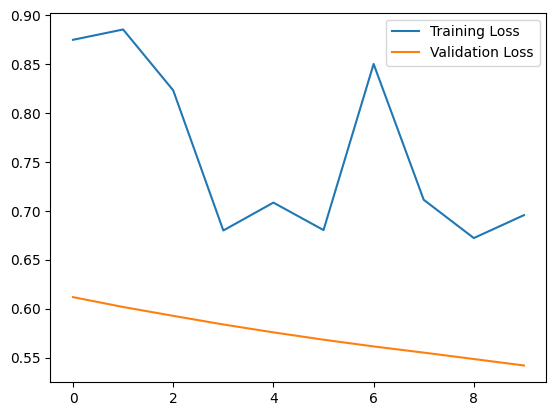

In [17]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

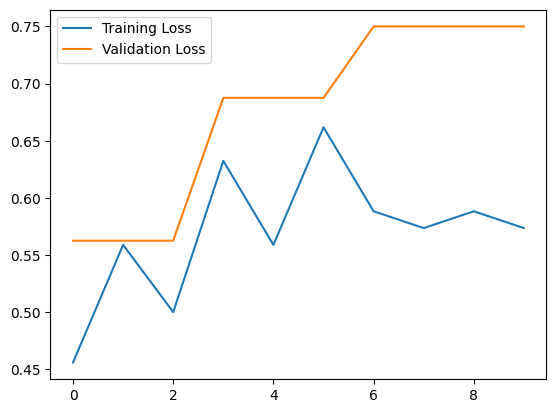

In [18]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()

### Save the model

In [20]:
# Save the base model
model.save('../../skin_cancer_model_baseline.keras')

# Save the transfer learning model
model2.save('../../skin_cancer_model_transfer.keras')